<IPython.core.display.Javascript object>


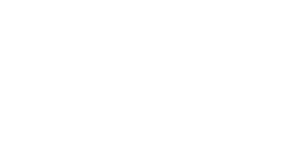

In [1]:
%matplotlib notebook
import sys
sys.path.append("/home/stachu/Projects/Anomaly_detection/Forecasting_models")

from predpy.dataset import TimeSeriesRecordsDataset
from predpy.dataset import SingleTimeSeriesDataset, MultiTimeSeriesDataset
from predpy.data_module import MultiTimeSeriesModule
from predpy.experimentator import (
    DatasetParams, ModelParams, ExperimentatorPlot,
    Experimentator, load_experimentator, plot_aggregated_predictions)
from predpy.preprocessing import set_index
from predpy.preprocessing import moving_average
from predpy.preprocessing import (
    load_and_preprocess, set_index, moving_average, drop_if_is_in,
    use_dataframe_func, loc, iloc)
from predpy.trainer import (
    CheckpointParams, TrainerParams, EarlyStoppingParams, LoggerParams)
from tsad.noiser import apply_noise_on_dataframes, white_noise

import pickle
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tsai.models import TCN, ResNet, TST, RNN, TransformerModel, FCN
import pandas as pd
from pytorch_lightning.loggers import TensorBoardLogger
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from ipywidgets import *
from predpy.preprocessing.statistic_anomalies_detection import *

# Experimentator run

In [2]:
window_size = 366

load_params = {
    "sep": ';', "header": 0, "low_memory": False,
    "infer_datetime_format": True, "parse_dates": {'datetime': [0, 1]},
    "index_col": ['datetime']
}

columns = ["Global_active_power", "Voltage"]
drop_refill_pipeline = [
    (loc, {"columns": columns}),
    (drop_if_is_in, (["?", np.nan]), {"columns": columns}),
    # (iloc, {"rows_end": 1500}),
    # (iloc, {"rows_start": -20000}),
]
preprocessing_pipeline = [
    (use_dataframe_func, "astype", "float"),
]
detect_anomalies_pipeline = [
#     (get_isoforest_filter, dict(
#         scores_threshold=-0.36, window_size=500, target="Global_active_power"))
]


datasets_params = [
    DatasetParams(
        path="/home/stachu/Projects/Anomaly_detection/Forecasting_models/data/Energy/household_power_consumption/household_power_consumption.csv",
        load_params=load_params,
        target="Global_active_power",
        split_proportions=[0.8, 0.1, 0.1],
        window_size=window_size,
        batch_size=64,
        DatasetCls=MultiTimeSeriesDataset,
        drop_refill_pipeline=drop_refill_pipeline,
        preprocessing_pipeline=preprocessing_pipeline,
        detect_anomalies_pipeline=detect_anomalies_pipeline,
        scaler=MinMaxScaler()),
]

c_in = 2
c_out = 1

models_params = [
    # ModelParams(
    #     name_="TST_l3_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 3, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.1", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.1}),
    # ModelParams(
    #     name_="TST_l2_fcDrop0.0", cls_=TST.TST,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "seq_len": window_size,
    #         "max_seq_len": window_size, "n_layers": 2, "fc_dropout": 0.0}),
    # ModelParams(
    #     name_="ResNet", cls_=ResNet.ResNet,
    #     init_params={"c_in": c_in, "c_out": c_out}),
    ModelParams(
        name_="LSTM_h200_l1", cls_=RNN.LSTM,
        init_params={
            "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 1}),
    # ModelParams(
    #     name_="LSTM_h200_l2", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 200, "n_layers": 2}),
    # ModelParams(
    #     name_="LSTM_h400_l1", cls_=RNN.LSTM,
    #     init_params={
    #         "c_in": c_in, "c_out": c_out, "hidden_size": 400, "n_layers": 1}),
]

chp_p = CheckpointParams(
    dirpath="../checkpoints", monitor='val_loss', verbose=True,
    save_top_k=1)
tr_p = TrainerParams(
    max_epochs=1, gpus=1, auto_lr_find=True,
    logger=TensorBoardLogger("../lightning_logs"))
es_p = EarlyStoppingParams(
    monitor='val_loss', patience=2, verbose=True)

In [3]:
exp = Experimentator(
    models_params=models_params,
    datasets_params=datasets_params,
    trainer_params=tr_p,
    checkpoint_params=chp_p,
    early_stopping_params=es_p
)

exp.run_experiments(experiments_path="../saved_experiments", safe=False)

# exp = load_experimentator(
#     "../saved_experiments/2021-12-11_16:34:50.pkl")

Global seed set to 42
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning:

Checkpoint directory ../checkpoints/household_power_consumption/LSTM_h200_l1 exists and is not empty.

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/stachu/anaconda3/envs/dl/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:423: LightningDeprecationWarning:

DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type    | Params
--------------------------------------
0 | model     | LSTM    | 163 K 
1 | criterion | MSELoss | 0     
--------------------------------------
163 K     Trainable params
0         Non-trainable params
163 K     Total params
0.654     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Global seed set to 42


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric val_loss improved. New best score: 0.000
Epoch 0, global step 25528: val_loss reached 0.00043 (best 0.00043), saving model to "/home/stachu/Projects/Anomaly_detection/Forecasting_models/checkpoints/household_power_consumption/LSTM_h200_l1/2021-12-16_17:19:21.ckpt" as top 1


Making predictions:   0%|          | 0/3192 [00:00<?, ?it/s]

# Data loading

In [4]:
tsm = exp.load_time_series_module(0)
df = pd.concat(tsm.sequences)
df = df.resample('1min').fillna("backfill")

In [5]:
from statsmodels.tsa.seasonal import seasonal_decompose

# fig = plt.figure(figsize=(16, 7))

result = seasonal_decompose(
    df["Global_active_power"],
    model='additive', period=1440,
    extrapolate_trend='freq')
# fig = result.plot()
# fig.set_size_inches(12, 5)

## Testing fillna method

In [8]:
# start = tsm.sequences[0].index[-1]
# for seq in tsm.sequences[1:]:
#     end = seq.index[0]
#     df.loc[start:end].plot()
#     start = seq.index[-1]

# Statistical anomaly detection plotting

## Collective Isolation Forest

In [9]:
# scores, if_model = collective_isolation_forest(ts, window_size, return_model=True)
# scores = collective_isolation_forest(df["Global_active_power"], 500)
scores = collective_isolation_forest(tsm.sequences[0]["Global_active_power"], 500)

In [16]:
df

,Global_active_power,Voltage
datetime,,
2006-12-16 17:24:00,0.374796,0.376090
2006-12-16 17:25:00,0.478363,0.336995
2006-12-16 17:26:00,0.479631,0.326010
2006-12-16 17:27:00,0.480898,0.340549
2006-12-16 17:28:00,0.325005,0.403231
...,...,...
2010-11-26 20:58:00,0.078762,0.556704
2010-11-26 20:59:00,0.078580,0.542811
2010-11-26 21:00:00,0.078037,0.536995


In [11]:
None = 1

SyntaxError: cannot assign to None (<ipython-input-11-d03f602a0186>, line 1)

In [5]:
threshold_widget = FloatSlider(
    value=-0.5,
    min=-1,
    max=0,
    step=0.001,
    description='Threshold',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
)

plot_interact_filtering(
    ts=tsm.sequences[0]["Global_active_power"], widgets={
        "scores_threshold": threshold_widget},
    filter_f=get_isoforest_filter, title="Remove isolation forest outliers",
    scores=scores);

NameError: name 'tsm' is not defined

## DWT clustering

In [ ]:
ts_distance_matrix(df["Global_active_power"], 1000000, True)

## Residual outliers

In [ ]:
threshold_widget = FloatSlider(
    value=0.7,
    min=min(result.resid),
    max=max(result.resid),
    step=(max(result.resid) - min(result.resid))/100,
    description='Threshold',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.1f',
)

plot_interact_filtering(
    ts=tsm.sequences[0]["Global_active_power"], widgets={
        "residual_threshold": threshold_widget},
    filter_f=get_residual_filter, title="Remove residual outliers",
    residuals=result.resid);

## Variance

In [ ]:
tmp = get_variance_filter(
    df["Global_active_power"], window_size=5000, log_variance_limits=(-4.6, -2))

In [ ]:
tmp = df["Global_active_power"].rolling(window=window_size, center=True).var()

%matplotlib inline
plt.cla()
tmp.loc["2008-07-16 17:24:00":"2008-09-20 17:24:00"].plot()
# df["Global_active_power"].loc["2008-07-16 17:24:00":"2008-09-20 17:24:00"].plot()
plt.show()

<IPython.core.display.Javascript object>


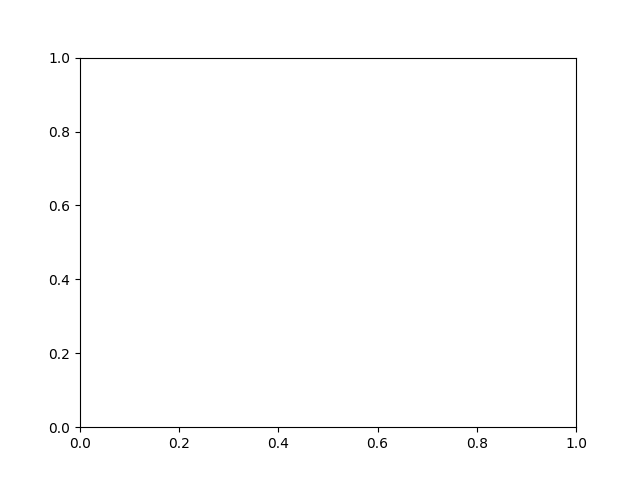

<IPython.core.display.Javascript object>


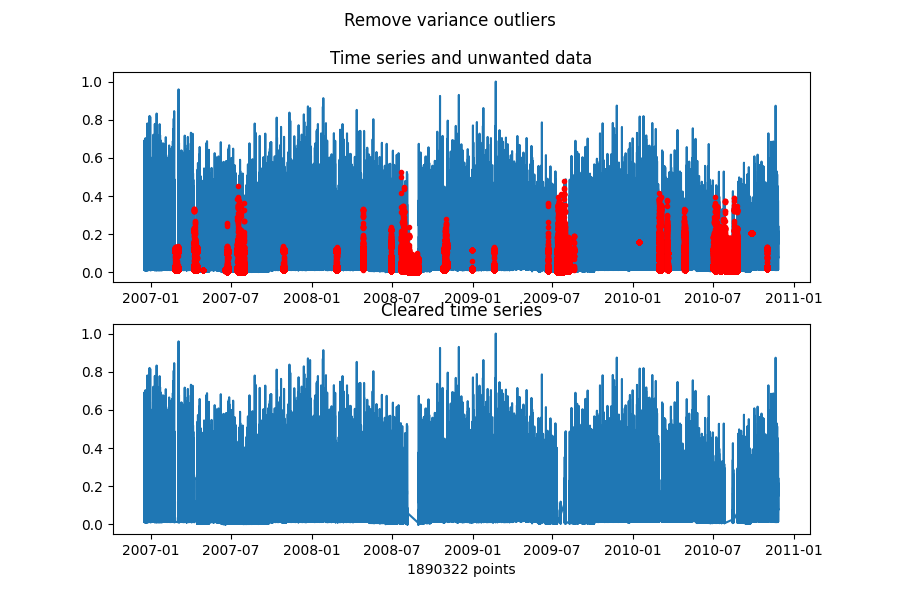

interactive(children=(IntSlider(value=30000, continuous_update=False, description='Window size', max=100000, m…

In [15]:
window_size_w = IntSlider(
    value=30000,
    min=100,
    max=100000,
    step=1,
    description='Window size',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

log_var_w = FloatRangeSlider(
    value=[-6, -2],
    min=-8,
    max=-2,
    step=0.1,
    description='Log variance',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True
)

plt.cla()
plot_interact_filtering(
    ts=df["Global_active_power"],
    widgets={
        "window_size": window_size_w,
        "log_variance_limits": log_var_w},
    filter_f=get_variance_filter, title="Remove variance outliers")

# Tslearn testing

In [ ]:
from tslearn.clustering import TimeSeriesKMeans
model = TimeSeriesKMeans(n_clusters=3, metric="dtw", max_iter=10)
model.fit(df)

In [ ]:
import matplotlib.pyplot as plt
y_pred = model.predict(ts)
sz = ts.shape[1]

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    xx = ts[y_pred == yi]
    plt.plot(xx, "k-", alpha=.2)
    # plt.xlim(0, sz)
    # plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

In [ ]:
import numpy
import matplotlib.pyplot as plt

from tslearn.clustering import KernelKMeans
from tslearn.datasets import CachedDatasets
from tslearn.preprocessing import TimeSeriesScalerMeanVariance

seed = 0
numpy.random.seed(seed)
X_train, y_train, X_test, y_test = CachedDatasets().load_dataset("Trace")
# Keep first 3 classes
X_train = X_train[y_train < 4]
numpy.random.shuffle(X_train)
# Keep only 50 time series
X_train = TimeSeriesScalerMeanVariance().fit_transform(X_train[:50])
sz = X_train.shape[1]

gak_km = KernelKMeans(n_clusters=3,
                      kernel="gak",
                      kernel_params={"sigma": "auto"},
                      n_init=20,
                      verbose=True,
                      random_state=seed)
y_pred = gak_km.fit_predict(X_train)

plt.figure()
for yi in range(3):
    plt.subplot(3, 1, 1 + yi)
    for xx in X_train[y_pred == yi]:
        print(xx.ravel())
        plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.xlim(0, sz)
    plt.ylim(-4, 4)
    plt.title("Cluster %d" % (yi + 1))

plt.tight_layout()
plt.show()

# Isolation Forest testing

In [ ]:
from sklearn.ensemble import IsolationForest

df = pd.concat(tsm.sequences)[["Global_active_power"]]
gap = (df['Global_active_power'].values.reshape(-1,1))
model_isoforest = IsolationForest()
model_isoforest.fit(gap)
scores = model_isoforest.score_samples(gap)
df['anomaly_scores'] = model_isoforest.score_samples(gap)
df['anomaly_classification'] = model_isoforest.predict(
    df['Global_active_power'].values.reshape(-1,1))

In [ ]:
df[df["anomaly_scores"] < -0.8]

In [ ]:
sub_df[(sub_df["anomaly_scores"] > -0.8) & (sub_df["Global_active_power"] > 0.609451)][["Global_active_power"]]

In [ ]:
# pd.options.plotting.backend = "plotly"
# df["anomaly_classification"] = df["anomaly_classification"].apply(lambda x: x - 3)
# ax = pd.DataFrame.plot()
# df[df["anomaly_scores"] > -0.40727][["Global_active_power"]].reset_index().plot(figsize=(25, 7), colormap="red", x="datetime", y="anomaly_classification", kind="scatter")
from matplotlib import pyplot as plt

plt.figure(figsize=(25, 7))

step = 5000
i = 9

sub_df = df[i*step:(i+1)*step]
plt.subplot(211)
plt.plot(sub_df[sub_df["anomaly_scores"] < -0.8][["Global_active_power"]].index, sub_df[sub_df["anomaly_scores"] < -0.8]["Global_active_power"], 'bo', color="red");
plt.plot(sub_df["Global_active_power"].index, sub_df["Global_active_power"]);

plt.subplot(212)
plt.plot(sub_df[sub_df["anomaly_scores"] >= -0.8].index, sub_df[sub_df["anomaly_scores"] >= -0.8]["Global_active_power"]);

In [ ]:
None = 1

# Anomaly predictor testing

In [ ]:
normal_dfs = tsm.get_data_from_range(start=-1000, end=-500, copy=True)
anomaly_dfs = tsm.get_data_from_range(start=-500, copy=True)

In [ ]:
anomaly_dfs[0].plot();

In [ ]:
apply_noise_on_dataframes(
    anomaly_dfs, make_noise=white_noise, negativity="abs", loc=0, scale=0.4)
anomaly_dfs[0].plot();

In [ ]:
from tsad.anomaly_detector import PredictionAnomalyDetector

model = exp.load_pl_model(
    model_idx=0,
    dir_path="../checkpoints/household_power_consumption/LSTM_h200_l1")

ad = PredictionAnomalyDetector(model)

ad.fit(
    train_data=DataLoader(
        MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    anomaly_data=DataLoader(
        MultiTimeSeriesDataset(anomaly_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    normal_data=DataLoader(
        MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
        batch_size=tsm.batch_size),
    class_weight={0: 0.8, 1: 0.2}, verbose=True, plot=True
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


anomaly_data=DataLoader(
    MultiTimeSeriesDataset(anomaly_dfs, tsm.window_size, tsm.target),
    batch_size=tsm.batch_size)
normal_data=DataLoader(
    MultiTimeSeriesDataset(normal_dfs, tsm.window_size, tsm.target),
    batch_size=tsm.batch_size)
normal_preds = ad._any_forward(normal_data, True)
anomaly_preds = ad._any_forward(anomaly_data, True)
plt.hist([
    ad.distributor.cdf(normal_preds).T[0], ad.distributor.cdf(anomaly_preds).T[0]],
    bins=30, label=["normal", "anomaly"]);

In [ ]:
# BTC = yf.Ticker("BTC-USD")
# # df = BTC.history(period="max", interval="1d", auto_adjust=False, actions=False)
# df = BTC.history(interval="1d", start="2014-09-17", end="2021-10-16", actions=False)
# df["Open-Close-diff"] = df.apply(lambda x: x["Close"] - x["Open"], axis=1)

# from datetime import datetime
# end = datetime.strptime("06-01-2017", '%m-%d-%Y')
# df = df.loc[:end]  # remove last years due to a change behaviour
# df = df[["Close", "Open-Close-diff"]]